# MobileNet

In [1]:
import os
import wandb
import pathlib
import tensorflow as tf
import pandas as pd

from bcd.model.repo import ExperimentRepo
from bcd.model.factory import MobileNetFactory
from bcd.model.transfer import FineTuner
from bcd.model.callback import Historian
from bcd.model.schedule import LinearThawSchedule, LogThawSchedule, LinearLearningRateSchedule, LogLearningRateSchedule
pd.set_option('display.max_rows',999)


## Configuration

In [2]:
# W&B
%env "WANDB_NOTEBOOK_NAME" "05_mobilenet.ipynb"
project = "breast_cancer_detection"

# Model Parameters
full_dataset = False
architecture='MobileNet'
model_name = "mobile_net" if full_dataset else "mobile_net_10"
version="v1_log"
name = f"{model_name}_{version}"
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
base_model_layer = 4 # Layer of the inception resnet base model
base_model_layers = 154 # layers in inception resnet model
loss = "binary_crossentropy"
activation = "sigmoid"

# Dataset params
batch_size = 64 if full_dataset else 32
input_shape = (224,224,3)
output_shape = 1
train_dir = pathlib.Path("data/image/1_final/training/training/").with_suffix('') if full_dataset else pathlib.Path("data/image/1_final/training_10/training/").with_suffix('') 
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Feature Extraction Parameters
initial_epochs = 100  # Number of epochs to train for feature extraction
fe_learning_rate = 1e-4

# Fine Tune Parameters
fine_tune_epochs = 10  # Number of epochs for each fine tune session
fine_tune_sessions = 5 # Number of fine tune sessions
fine_tune_min_lr = 1e-8
fine_tune_max_lr = 1e-4
fine_tune_thaw_schedule = "log"


# Early stop parameters 
es_min_delta = 0.0001
es_monitor = "val_loss"  # Monitor validation loss for early stopping
es_patience = 8  # The number of consecutive epochs for which lack of improvement is tolerated 
es_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.
es_verbose = 1
es_session_patience = None # The number of fine tuning sessions for which lack of improvement is tolerated. If None, no early stopping at session level

# Reduce LR on Plateau Parameters
rlr_monitor = "val_loss"
rlr_factor = 0.5
rlr_patience = 3
rlr_verbose = 1
rlr_mode = "auto"
rlr_min_delta = 0.0001
rlr_min_lr=1e-10

# ModelCheckpoint Callback parameters
mcp_location = "models/"
mcp_mode = "auto"
mcp_save_weights_only = False
mcp_save_best_only = True
mcp_save_freq = "epoch"
mcp_verbose = 1

# Historian parameters
filename = f"{name}_history.pkl"
historian_filepath = os.path.join("models", name, filename)



env: "WANDB_NOTEBOOK_NAME"="05_mobilenet.ipynb"


## Experiment Setup

In [3]:
config = {
    "architecture": architecture,
    "model_name": model_name,
    "version": version,
    "dataset": "CBIS-DDSM-10",
    "batch_size": batch_size,
    "initial_epochs": initial_epochs,
    "fine_tune_epochs": fine_tune_epochs,
    "fine_tune_sessions": fine_tune_sessions,
    "fine_tune_min_lr": fine_tune_min_lr,
    "fine_tune_max_lr": fine_tune_max_lr,
    "fine_tune_schedule": fine_tune_thaw_schedule,
    "early_stop_min_delta": es_min_delta,
    "early_stop_monitor": es_monitor,
    "early_stop_patience": es_patience,
    "early_stop_restore_best_weights": es_restore_best_weights,
    "early_stop_verbose": es_verbose,
    "rlr_monitor": rlr_monitor,
    "rlr_factor": rlr_factor,
    "rlr_patience": rlr_patience,
    "rlr_verbose": rlr_verbose,
    "rlr_mode": rlr_mode,
    "rlr_min_delta": rlr_min_delta,
    "rlr_min_lr": rlr_min_lr
    
}

In [4]:
run = wandb.init(project=project, config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: aistudio. Use `wandb login --relogin` to force relogin


## Load Data

In [5]:
# Training DataSet (10%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Dependencies
Several dependencies will be used throughout this notebook, including:
- Early Stop Callback
- Reduce Learning Rate on Plateau Callback
- Model Repository
- ResNet Model Factory
- Historian Callback

We'll make those objects available here.

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       min_delta=es_min_delta,
                                                       patience=es_patience, 
                                                       restore_best_weights=es_restore_best_weights,
                                                       verbose=es_verbose)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=rlr_monitor,
                                                          factor=rlr_factor,
                                                          patience=rlr_patience,
                                                          verbose=rlr_verbose,
                                                          mode=rlr_mode,
                                                          min_delta=rlr_min_delta,
                                                          min_lr=rlr_min_lr)
wandb_callback = wandb.keras.WandbMetricsLogger()

repo = ExperimentRepo(location=mcp_location)

factory = MobileNetFactory()

historian = Historian(name=name)

if fine_tune_thaw_schedule == "linear":
    thaw_schedule = LinearThawSchedule(sessions=fine_tune_sessions, 
                                    base_model_layer=base_model_layer, 
                                    n_layers=len(factory.base_model.layers))
    learning_rate_schedule = LinearLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)

else:
    thaw_schedule = LogThawSchedule(sessions=fine_tune_sessions, 
                                   base_model_layer=base_model_layer, 
                                   n_layers=len(factory.base_model.layers))



    learning_rate_schedule = LogLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)


## Feature Extraction
If the model already exists, obtain it from the repository. Otherwise, create the model and perform feature extraction.

In [7]:
stage = "feature_extraction"
if force or not repo.exists(name=name, stage=stage):
    model = factory.create(input_shape=input_shape, 
                            output_shape=output_shape,
                            activation=activation)
    # Create the optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=fe_learning_rate)

    # Compile the Model
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,        
    )

    # Delete existing checkpoints
    repo.remove(name=name, stage=stage)
    # Summarize the model
    model.summary()
    # Obtain a checkpoint callback from the model repository 
    checkpoint_callback = repo.create_callback(name=name, stage=stage)
    # Set the session on the historian to 0 for feature extraction
    historian.on_session_begin(session=0)
    # Fit the model with callbacks
    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=initial_epochs, 
                        callbacks=[checkpoint_callback, 
                                   reduce_lr_callback,
                                   early_stop_callback, 
                                   wandb_callback,                                   
                                   historian])        
    # Register the model on wandb
    filepath = repo.get_filepath(name=name, stage=stage)    
    artifact = wandb.Artifact(f"{name}-{stage}-{run.id}", type="model")
    artifact.add_file(filepath)
    wandb.log_artifact(artifact, aliases=[stage, "best"])
    wandb.run.link_artifact(artifact, "aistudio/breast_cancer_detection/InceptionResnet")
else:
    # Obtain the model from the repository
    model = repo.get(name=name, stage=stage)
    # Obtain the historian
    historian = historian.load(historian_filepath)    
    # Summarize the model
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                      

2024-01-28 09:49:18.274053: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://27136223-bc9c-4d0b-b90d-3216375274cb/assets
INFO:tensorflow:Assets written to: ram://27136223-bc9c-4d0b-b90d-3216375274cb/assets


ArtifactManifestEntry(path='mobile_net_10_v1_log_feature_extraction_18-val_loss_0.64.keras', digest='4iftbVtWJRBnvuxol6I/bw==', size=9363360, local_path='/home/john/.local/share/wandb/artifacts/staging/tmp2g2e388z')

<Artifact mobile_net_10_v1_log-feature_extraction-usbma03r>

wandb: Waiting for artifact mobile_net_10_v1_log-feature_extraction-usbma03r to be committed...



wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-feature_extraction-usbma03r:v0


## Fine Tuning

In [8]:
ft = FineTuner(name=name, 
               train_ds=train_ds, 
               validation_ds=val_ds, 
               repo=repo,
               thaw_schedule=thaw_schedule,
               learning_rate_schedule=learning_rate_schedule,               
               metrics=metrics,
               fine_tune_epochs=fine_tune_epochs,
               sessions=fine_tune_sessions,
               callbacks=[early_stop_callback, reduce_lr_callback, wandb_callback],
               )
ft.tune(model=model, historian=historian, force=force)
run.finish()



INFO:LogThawSchedule:Thawed 2 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenet

wandb: Waiting for artifact mobile_net_10_v1_log-fine_tuning_session_1-usbma03r to be committed...

wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-fine_tuning_session_1-usbma03r:v0




INFO:LogThawSchedule:Thawed 5 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 1e-05
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenetv

wandb: Waiting for artifact mobile_net_10_v1_log-fine_tuning_session_2-usbma03r to be committed...

wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-fine_tuning_session_2-usbma03r:v0




INFO:LogThawSchedule:Thawed 17 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 1e-06
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenet

wandb: Waiting for artifact mobile_net_10_v1_log-fine_tuning_session_3-usbma03r to be committed...

wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-fine_tuning_session_3-usbma03r:v0




INFO:LogThawSchedule:Thawed 51 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 1e-07
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenet

wandb: Waiting for artifact mobile_net_10_v1_log-fine_tuning_session_4-usbma03r to be committed...

wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-fine_tuning_session_4-usbma03r:v0




INFO:LogThawSchedule:Thawed 154 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 1e-08
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilene

wandb: Waiting for artifact mobile_net_10_v1_log-fine_tuning_session_5-usbma03r to be committed...

wandb: Committed artifact aistudio/breast_cancer_detection/mobile_net_10_v1_log-fine_tuning_session_5-usbma03r:v0
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch/accuracy,▁▅▄▃▆▃▃▂▃▆▃▄▅▅▄▄▃▄▅▆▃▄▄▇█▄▄▄▅▅▆▅▄▅▅▅▄▆▃▆
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,██████▄▄▄▄▄▄▃▂▂██▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▅▅▃▅▅▅▅▃▅▃▃▃▄▄▄▃▄▃▃▃▃▂▁▄▄▃▃▂▃▃▃▂▃▄▄▂▄▃
epoch/lr,██████▄▄▄▄▄▄▃▃▂██▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▃▄▃▂▅▂▃▁▂▆▂▃▅▄▃▃▃▃▄▆▃▄▄▇█▂▄▄▄▄▅▅▃▄▄▄▃▇▃▅
epoch/recall,█▆▄▃▃▄▄▂▂▅▂▃▄▂▃▂▄▃▄▄▃▃▃▅▇▁▄▄▃▃▃▄▄▃▃▂▂▂▄▄
epoch/val_accuracy,▁▆██▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▃█▁▃▃▁▁▁▁▃▃▃▃▃▃▃▃▃▃
epoch/val_loss,▇▄▃▃▃▃▃▂▂▂▁▂▂▂▂▁▂▂▂▁▁██▆▇▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch/val_precision,▂▃██▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▂▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂
epoch/val_recall,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▄▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Learning Curves

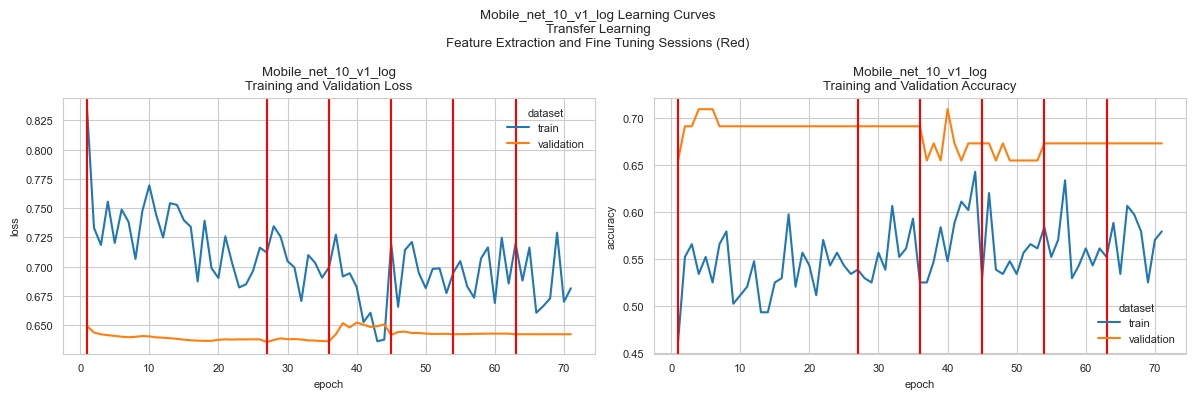

In [9]:
# Plot the historian
historian.plot_learning_curves()

## Evaluation